#pytorch
from:

*  https://huggingface.co/docs/transformers/training
*  https://github.com/DimasDMM/text-classification


*   https://www.youtube.com/watch?v=vNKIg8rXK6w





# installation

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.9 MB/s 
     |████████████████████████████████| 163 kB 50.1 MB/s 
     |████████████████████████████████| 7.6 MB 33.6 MB/s 


# import

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_fscore_support
import torch
from transformers import TrainingArguments, Trainer
from transformers import  AutoModelForSequenceClassification, AutoTokenizer ,BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback


from collections import Counter
import matplotlib.pyplot as plt
import regex as re
import statistics
import math

# Prepare dataset

In [3]:
# Mounting Google Drive
from google.colab import drive  # to mount Google Drive to Colab notebook
drive.mount('/content/gdrive')
path='./gdrive/My Drive/Colab Notebooks/'



Mounted at /content/gdrive


In [ ]:
df = pd.read_csv(path+'Children-Books(128new).csv')
df.head()

,Title,Author,Moral,Content
0,Meera and Ameera,Nimmy Chacko,Friendship,Meera and I are a team. She’s my most favourit...
1,Every Minute Counts,Shabnam Minwalla,Friendship,Adil is always late to school.\nHis class teac...
2,Mali's Friend,Rujeko Moyo,Friendship,Mali enjoys playing by himself.\nHe likes to b...
3,My Best Friend – short story with imagination,Anupa,Friendship,I have a friend. She lives in my house.\n\nWhe...
4,Same-Same or Different? Being friends despite ...,Roopa Pai,Friendship,Mamma put Sparrow’s lunchbox into her schoolba...


In [ ]:
df = df[['Content','Moral']]
df.head(2)

,Content,Moral
0,Meera and I are a team. She’s my most favourit...,Friendship
1,Adil is always late to school.\nHis class teac...,Friendship


# **Dataset analysis**
As you can see in the following plot, the samples are  balanced. if its unbalenced this could cause problems during the training but, since they balanced, I have left it as it is.
In other cases, such as fraud detecting where the positive classes are very few compared to the negative ones, we must apply techniques to balance it. For example, we could undersample the biggest category.

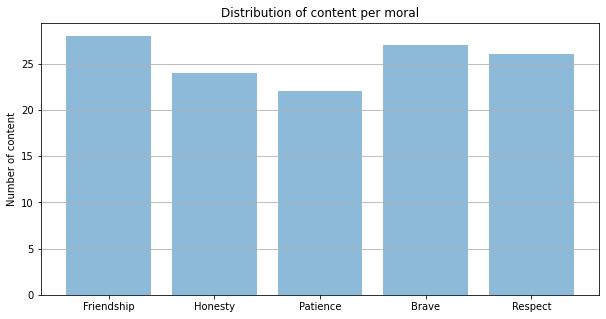

Counter({'Friendship': 28, 'Brave': 27, 'Respect': 26, 'Honesty': 24, 'Patience': 22})


In [ ]:
Morals = df[['Moral']].values.reshape(-1)

counter_Morals = Counter(Morals)
Moral_names = counter_Morals.keys()
Moral_values = counter_Morals.values()

y_pos = np.arange(len(Moral_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, Moral_values, align='center', alpha=0.5)
plt.xticks(y_pos, Moral_names)
plt.ylabel('Number of content')
plt.title('Distribution of content per moral')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_Morals)

In [ ]:
def calculate_stats(df, split_char=' '):
    Morals = df['Moral'].unique()
    
    all_lengths = []
    per_Moral = {
        'lengths': {c:[] for c in Morals},
        'mean': {c:0 for c in Morals},
        'stdev': {c:0 for c in Morals}
    }

    for index, row in df.iterrows():
        Content = row['Content']
        Content = re.sub(r"\s+", ' ', Content) # Normalize
        Content = Content.split(split_char)
        l = len(Content)
        
        Moral = row['Moral']
        
        all_lengths.append(l)
        per_Moral['lengths'][Moral].append(l)
    
    for c in Morals:
         per_Moral['mean'][c] = statistics.mean( per_Moral['lengths'][c])
         per_Moral['stdev'][c] = statistics.stdev( per_Moral['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_Moral': pd.DataFrame( per_Moral)
    }


def display_lengths_histograms(df_stats, n_cols=3):
    Morals = df['Moral'].unique()
    n_rows = math.ceil(len(Morals) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All Moral')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in Morals:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Moral: %s' % c)
        
        lengths = df_stats['per_Moral']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()


In [ ]:
df_stats = calculate_stats(df)
df_stats['per_Moral']

,lengths,mean,stdev
Friendship,"[186, 324, 211, 119, 559, 223, 364, 476, 569, ...",284.964286,363.496343
Honesty,"[172, 240, 330, 494, 436, 804, 192, 591, 370, ...",273.500000,227.751772
Patience,"[407, 534, 262, 595, 261, 220, 144, 365, 764, ...",272.272727,346.179582
Brave,"[1165, 801, 205, 511, 500, 498, 776, 319, 631,...",319.518519,329.181546
Respect,"[231, 364, 445, 609, 227, 480, 222, 417, 392, ...",185.461538,183.138031


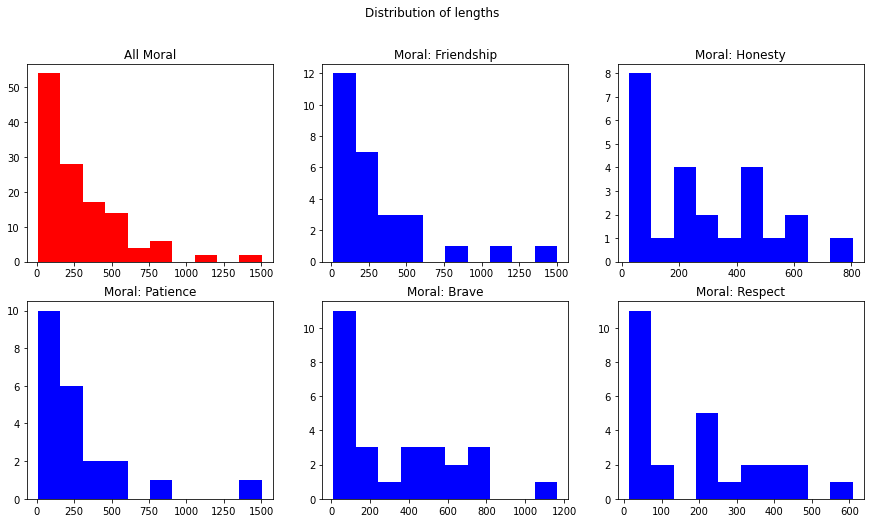

In [ ]:
display_lengths_histograms(df_stats)

In [5]:
df['Moral'] = df['Moral'].map({'Friendship':0,'Honesty':1,'Patience':2,'Brave':3,'Respect':4})

NameError: ignored

# toknize & encode
add Codeadd Markdown I am going to import the RoBERTa model from HuggingFace. Note that I must import not only the model but also the tokenizer (since I must use the same vocabulary as the model was trained with). We should take into account that RoBERTa's input accepts up-to 512 tokens, thus we must truncate the tokenized texts. In my case, I truncate to max_length=512 tokens. See https://huggingface.co/roberta-base

In [ ]:

# Define pretrained tokenizer and model
model_name = "roberta-base"
# Import tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model.to(device)
# print(f'Using {device}')
# ----- 1. Preprocess data -----#
# Preprocess data
X = list(df["Content"])
y = list(df["Moral"])
# Split into train and test datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

# Create RoBERTa **model**

In [4]:

# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters
def compute_metrics(pred):
   
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall}

output_dir = "output"
# Define Trainer
args = TrainingArguments(
    output_dir= output_dir,
    evaluation_strategy="steps",
    eval_steps=15,
    logging_steps =15 ,
    save_steps=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    seed=0,
    
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)


NameError: ignored

# **train model**

In [ ]:
# Train pre-trained model
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 101
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78
  Number of trainable parameters = 124649477


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
15,1.518300,1.461601,0.423077,0.409790,0.553419,0.423077
30,1.071900,0.849052,0.769231,0.775000,0.820513,0.769231
45,0.548200,0.852300,0.653846,0.685897,0.746795,0.653846
60,0.435900,0.661806,0.807692,0.809402,0.833333,0.807692
75,0.258300,0.754738,0.769231,0.770606,0.787879,0.769231


***** Running Evaluation *****
  Num examples = 26
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to output/checkpoint-15
Configuration saved in output/checkpoint-15/config.json
Model weights saved in output/checkpoint-15/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 26
  Batch size = 8
Saving model checkpoint to output/checkpoint-30
Configuration saved in output/checkpoint-30/config.json
Model weights saved in output/checkpoint-30/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 26
  Batch size = 8
Saving model checkpoint to output/checkpoint-45
Configuration saved in output/checkpoint-45/config.json
Model weights saved in output/checkpoint-45/pytor

TrainOutput(global_step=78, training_loss=0.7453862084792211, metrics={'train_runtime': 3882.2851, 'train_samples_per_second': 0.156, 'train_steps_per_second': 0.02, 'total_flos': 159449594333184.0, 'train_loss': 0.7453862084792211, 'epoch': 6.0})

**evaluation**

In [ ]:
metrics=trainer.evaluate()
print(metrics)

***** Running Evaluation *****
  Num examples = 26
  Batch size = 8


{'eval_loss': 0.7487834095954895, 'eval_accuracy': 0.7692307692307693, 'eval_f1': 0.7948717948717948, 'eval_precision': 0.8717948717948718, 'eval_recall': 0.7692307692307693, 'eval_runtime': 47.8381, 'eval_samples_per_second': 0.543, 'eval_steps_per_second': 0.084, 'epoch': 4.0}


**save model**

In [ ]:
classifier_directory = "./drive/My Drive/Colab Notebooks/classifier_directory"
tokenizer.save_pretrained(classifier_directory)
model.save_pretrained(classifier_directory)

tokenizer config file saved in ./drive/My Drive/Colab Notebooks/classifier_directory/tokenizer_config.json
Special tokens file saved in ./drive/My Drive/Colab Notebooks/classifier_directory/special_tokens_map.json
Configuration saved in ./drive/My Drive/Colab Notebooks/classifier_directory/config.json
Model weights saved in ./drive/My Drive/Colab Notebooks/classifier_directory/pytorch_model.bin


# **predict** 

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
def prediction(X_test):
  X_test = ['']
  # X_test = ['There was a girl called Rose who loved to sleep with her parents because she afraid to sleep alone. Her parents used to tuck her up in bed every night, but she always went to their bed in the middle of the night: “Can I sleep with you?” – she would ask.Her parent always let her sleep with them, but she was not a baby anymore, so, one day they told her:– “Rose, you are a big girl now, and you can´t sleep with us every night. Big girls have to sleep in their own beds, so we want to help you do that by singing you a song at bedtime.”Rose couldn´t wait until bedtime to hear the song. Her parents finally arrived to her room to sing their song: “Twinkle, twinkle, little star… how I wonder what you are…”Rose fell asleep, and didn´t wake up during the night.She had learnt to confront her fear and to be brave girl and  sleep alone and from that day used to wake up in a good mood singing “twinkle, twinkle, little star… ']
  X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

  # Create torch dataset
  test_dataset = Dataset(X_test_tokenized)

  # Load trained model
  model_path = "./gdrive/My Drive/Colab Notebooks/classifier_directory"
  model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=5)

  # Define test trainer
  test_trainer = Trainer(model)

  # Make prediction
  raw_pred, _, _ = test_trainer.predict(test_dataset)

  # Preprocess raw predictions
  y_pred = np.argmax(raw_pred, axis=1)
  if y_pred == 0:
    return 'Friendship'
  elif y_pred == 1:
    return 'Honesty'
  elif y_pred == 2:
    return 'Patience'
  elif y_pred == 3:
    return 'Brave'
  elif y_pred == 4:
    return 'Respect'

prediction(['X_test'])


loading configuration file ./gdrive/My Drive/Colab Notebooks/artifacts/classifier_directory3/config.json
Model config RobertaConfig {
  "_name_or_path": "./gdrive/My Drive/Colab Notebooks/artifacts/classifier_directory3",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_

'Respect'